### Installation

In [ ]:
# !pip install torch torchvision torchaudio
# !pip install nltk tqdm
# !pip install datasets
# !pip install torchtext

## Load and Explore the SNLI Dataset

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
import re
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download("punkt")


[nltk_data] Downloading package punkt to /scratch/rpt5409/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Load the dataset
dataset = load_dataset("snli")

# Convert to Pandas DataFrame for exploration
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

# Show sample data
df_train.head()


,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0


In [6]:
df_train.tail()

,premise,hypothesis,label
550147,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2
550148,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1
550149,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1
550150,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2
550151,A man is surfing in a bodysuit in beautiful bl...,On the beautiful blue water there is a man in ...,0


In [7]:
# prompt: df_train : 0th index print; each separate .... df_train.iloc[0]["premise"]
if len(df_train) > 5:
  for i in range(5):
      print("premise:", end="")
      print(df_train.iloc[i]["premise"])
      print("hypothesis:", end="")
      print(df_train.iloc[i]["hypothesis"])
      print("label:", end="")
      print(df_train.iloc[i]["label"])
      print("===============================")


premise:A person on a horse jumps over a broken down airplane.
hypothesis:A person is training his horse for a competition.
label:1
premise:A person on a horse jumps over a broken down airplane.
hypothesis:A person is at a diner, ordering an omelette.
label:2
premise:A person on a horse jumps over a broken down airplane.
hypothesis:A person is outdoors, on a horse.
label:0
premise:Children smiling and waving at camera
hypothesis:They are smiling at their parents
label:1
premise:Children smiling and waving at camera
hypothesis:There are children present
label:0


0: "Entailment", 1: "Contradiction", 2: "Neutral"

# Check Data Distribution
What We Check
Label distribution: Are classes balanced?

Text length: Helps decide padding length.

### If we keep, unlabeled data then what is the distribution

/tmp/ipykernel_602666/1155726302.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")


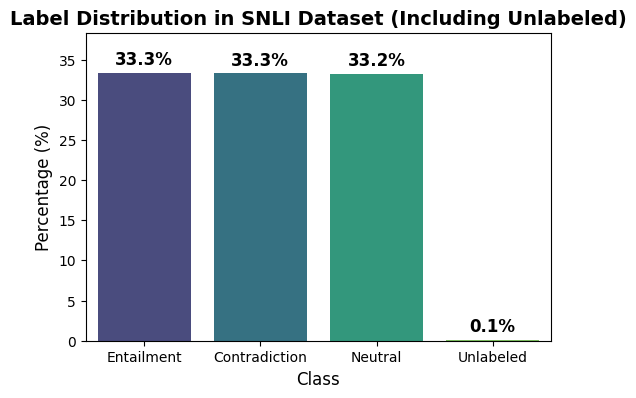

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

# Load SNLI dataset
dataset = load_dataset("snli")
df_train = pd.DataFrame(dataset["train"])

# Assuming df_train is already loaded
# Define label mapping (including -1 as "Unlabeled")
label_names = {0: "Entailment", 1: "Neutral", 2: "Contradiction", -1: "Unlabeled"}
df_train["label_text"] = df_train["label"].map(label_names)

# Compute label distribution
label_counts = df_train["label_text"].value_counts(normalize=True) * 100  # Convert to percentages

# Create bar plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")

# Fix text positioning and font size
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight="bold")

# Final formatting
plt.title("Label Distribution in SNLI Dataset (Including Unlabeled)", fontsize=14, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, max(label_counts.values) + 5)  # Add padding for better readability
plt.show()


In [9]:

print(df_train["label"].unique())


[ 1  2  0 -1]


## Removing unlabeled data

In [10]:
# Remove invalid labels (-1)
df_train = df_train[df_train["label"] != -1]

In [11]:
# Define label mapping
label_names = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
df_train["label_text"] = df_train["label"].map(label_names)

# Compute sentence lengths
nltk.download("punkt_tab")
df_train["premise_length"] = df_train["premise"].apply(lambda x: len(word_tokenize(x)))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x: len(word_tokenize(x)))



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /scratch/rpt5409/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


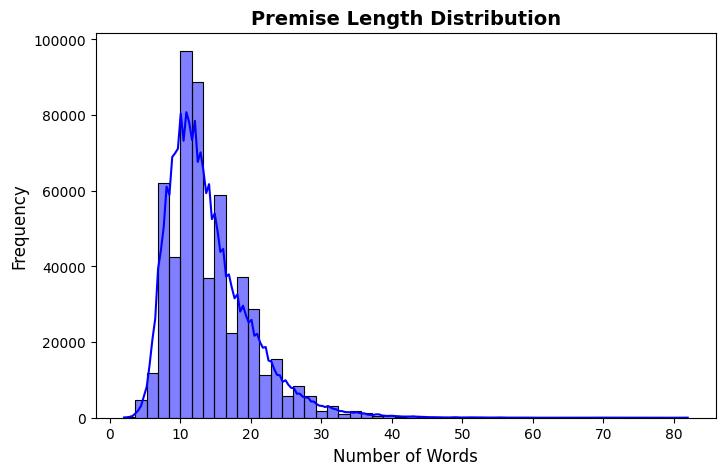

In [12]:
# Plot 1: Premise Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_train["premise_length"], bins=50, kde=True, color="blue")
plt.title("Premise Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()



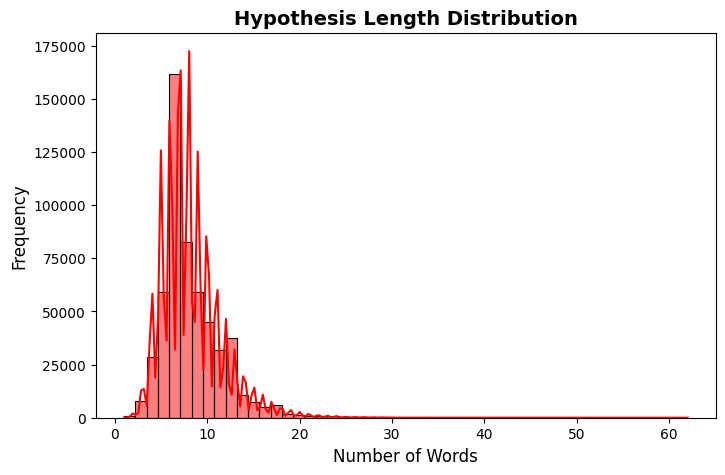

In [13]:
# Plot 2: Hypothesis Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_train["hypothesis_length"], bins=50, kde=True, color="red")
plt.title("Hypothesis Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()



/tmp/ipykernel_602666/2033641802.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")


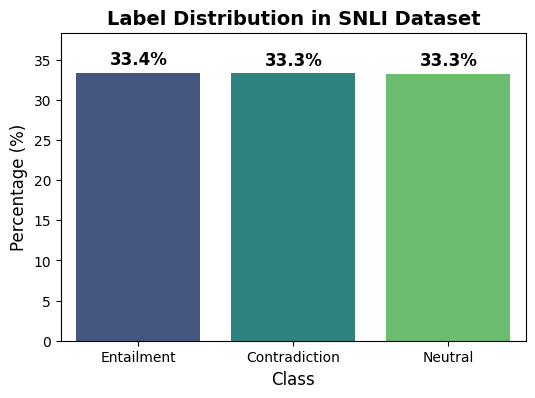

In [14]:
# Plot 3: Label Distribution (Percentage Bar Chart)
label_counts = df_train["label_text"].value_counts(normalize=True) * 100  # Convert to percentages
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, palette="viridis")

# Fix text positioning and font size
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight="bold")

# Final formatting
plt.title("Label Distribution in SNLI Dataset", fontsize=14, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, max(label_counts.values) + 5)  # Add padding for better readability
plt.show()

[nltk_data] Downloading package punkt to /scratch/rpt5409/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


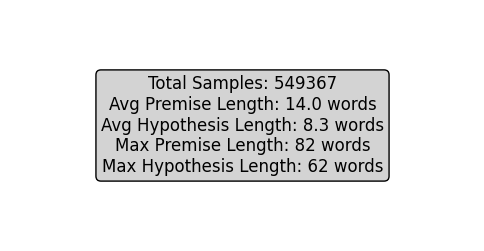

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

# Load SNLI dataset
dataset = load_dataset("snli")
df_train = pd.DataFrame(dataset["train"])

# Remove invalid labels (-1)
df_train = df_train[df_train["label"] != -1]

# Compute sentence lengths
nltk.download("punkt")
df_train["premise_length"] = df_train["premise"].apply(lambda x: len(word_tokenize(x)))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x: len(word_tokenize(x)))

# Generate statistics
total_samples = len(df_train)
avg_premise_len = df_train["premise_length"].mean()
avg_hypothesis_len = df_train["hypothesis_length"].mean()
max_premise_len = df_train["premise_length"].max()
max_hypothesis_len = df_train["hypothesis_length"].max()

# Create a blank plot for text display
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("off")  # Hide axes

# Dataset summary text
text_info = (
    f"Total Samples: {total_samples}\n"
    f"Avg Premise Length: {avg_premise_len:.1f} words\n"
    f"Avg Hypothesis Length: {avg_hypothesis_len:.1f} words\n"
    f"Max Premise Length: {max_premise_len} words\n"
    f"Max Hypothesis Length: {max_hypothesis_len} words"
)

# Add text inside the plot with background color
ax.text(0.5, 0.5, text_info, fontsize=12, verticalalignment="center",
        horizontalalignment="center", bbox=dict(boxstyle="round", facecolor="lightgrey"))

# Show the plot
plt.show()


In [16]:
print(text_info)

Total Samples: 549367
Avg Premise Length: 14.0 words
Avg Hypothesis Length: 8.3 words
Max Premise Length: 82 words
Max Hypothesis Length: 62 words


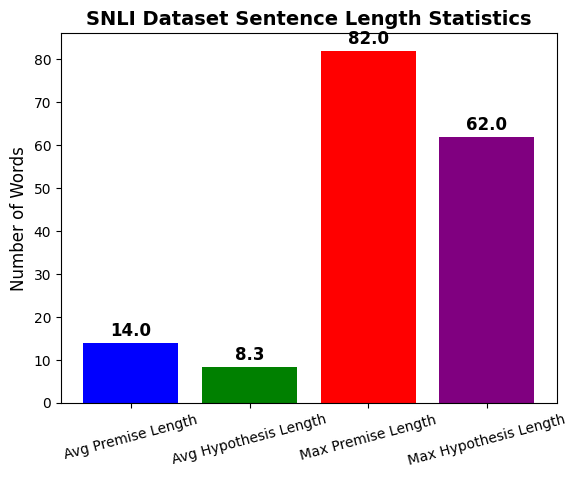

In [22]:
# Data for bar chart (excluding "Total Samples")
labels = ["Avg Premise Length", "Avg Hypothesis Length", "Max Premise Length", "Max Hypothesis Length"]

avg_premise_len = df_train["premise_length"].mean()
avg_hypothesis_len = df_train["hypothesis_length"].mean()
max_premise_len = df_train["premise_length"].max()
max_hypothesis_len = df_train["hypothesis_length"].max()

values = [avg_premise_len, avg_hypothesis_len, max_premise_len, max_hypothesis_len]
# Create bar chart
# plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=["blue", "green", "red", "purple"])

# Add values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + max(values) * 0.02, f"{v:.1f}", ha='center', fontsize=12, fontweight="bold")

# Formatting
plt.title("SNLI Dataset Sentence Length Statistics", fontsize=14, fontweight="bold")
plt.ylabel("Number of Words", fontsize=12)
plt.xticks(rotation=15)  # Rotate labels for readability

# Show plot
plt.show()

In [17]:
len(df_train)

549367

In [18]:
len(df_test)

10000

In [19]:
len(df_val)

10000

### Step 3: Preprocess

In [23]:
import re
import nltk
from nltk.tokenize import word_tokenize



# Function to clean and tokenize text
def preprocess_text(text):
    text = text.lower().strip()  # Lowercasing and removing unnecessary spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    return word_tokenize(text)  # Tokenize words

# Function to preprocess SNLI dataset
def preprocess_snli_data(df):
    pairs, labels = [], []

    # Define the correct label mapping
    label_map = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}  # Fixed mapping

    for i, row in df.iterrows():
        if row["label"] != -1:  # Removing invalid labels (-1)
            premise = preprocess_text(row["premise"])
            hypothesis = preprocess_text(row["hypothesis"])
            pairs.append((premise, hypothesis))
            labels.append(row["label"])

    return pairs, labels


In [24]:

# Apply preprocessing to train, validation, and test sets
df_train = df_train[df_train["label"] != -1]  # Remove invalid labels
df_val = df_val[df_val["label"] != -1]
df_test = df_test[df_test["label"] != -1]



In [25]:
len(df_train)

549367

In [26]:
len(df_val)

9842

In [27]:
len(df_test)

9824

In [28]:
train_pairs, train_labels = preprocess_snli_data(df_train)
val_pairs, val_labels = preprocess_snli_data(df_val)
test_pairs, test_labels = preprocess_snli_data(df_test)




In [29]:
# Print sample to verify preprocessing
print("Sample Preprocessed Data:")
print("Premise:", train_pairs[0][0])
print("Hypothesis:", train_pairs[0][1])
print("Label:", train_labels[0])

Sample Preprocessed Data:
Premise: ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane']
Hypothesis: ['a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition']
Label: 1


In [30]:
len(train_pairs)

549367

### Step 4: Word Embeddings (GloVe)

Step 1: Download GloVe Embeddings

In [31]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip


 Step 2: Load GloVe into Python

Changing to embedding_dim = 300

In [32]:
import numpy as np

# Path to GloVe embeddings (change dim=50 if using another size)
glove_path = "glove.6B.50d.txt"
embedding_dim = 50

# Load GloVe embeddings into a dictionary
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]  # First value is the word
            vector = np.array(values[1:], dtype=np.float32)  # The rest are the vector values
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings(glove_path)
print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


###  4.2 Build Vocabulary

In [33]:
# Special tokens
word_to_index = {"<PAD>": 0, "<UNK>": 1}  # PAD for padding, UNK for unknown words
index_to_word = ["<PAD>", "<UNK>"]

# Populate vocabulary from training data
for premise, hypothesis in train_pairs:
    for word in premise + hypothesis:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)
            index_to_word.append(word)

# Vocabulary size
vocab_size = len(word_to_index)
print(f"Vocabulary Size: {vocab_size}")


Vocabulary Size: 35937


### Step 4.3: Create the Embedding Matrix

In [34]:
import torch

# Initialize embedding matrix
vocab_size = len(word_to_index)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Assign GloVe embeddings, use random for missing words
for word, idx in word_to_index.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Random for unknown words

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

print("Final Embedding Matrix Shape:", embedding_matrix.shape)


Final Embedding Matrix Shape: torch.Size([35937, 50])


### Step 5: Convert data into tensor format

Step 5.1: Encode Sentences as Word Indexes

In [35]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

# Define max sequence length based on data analysis (Step 2)
MAX_LENGTH = 500  # Most sentences are within 500 words

# Function to encode sentences into word indices
def encode_sentence(sentence, max_len=MAX_LENGTH):
    encoded = [word_to_index.get(word, 1) for word in sentence]  # 1 is "<UNK>"
    return torch.tensor(encoded[:max_len])  # Truncate if longer than max_len


In [36]:

# Convert dataset into tensor format
def encode_data(pairs, labels, max_len=MAX_LENGTH):
    premises = [encode_sentence(p, max_len) for p, h in pairs]
    hypotheses = [encode_sentence(h, max_len) for p, h in pairs]
    labels = torch.tensor(labels).unsqueeze(1)  # Fix: Ensure labels have correct shape

    # Pad sequences to make them the same length
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=0)
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=0)

    return premises_padded, hypotheses_padded, labels



# Encode train, validation, and test sets
train_prem, train_hyp, train_labels = encode_data(train_pairs, train_labels)
val_prem, val_hyp, val_labels = encode_data(val_pairs, val_labels)
test_prem, test_hyp, test_labels = encode_data(test_pairs, test_labels)

# Print shape of data
print("Train Premises Shape:", train_prem.shape)
print("Train Hypotheses Shape:", train_hyp.shape)
print("Train Labels Shape:", train_labels.shape)

Train Premises Shape: torch.Size([549367, 78])
Train Hypotheses Shape: torch.Size([549367, 56])
Train Labels Shape: torch.Size([549367, 1])


Step 5.2: Create DataLoader for Efficient Batching

In [37]:
# Define batch size
BATCH_SIZE = 64

# Create TensorDataset and DataLoader
train_data = TensorDataset(train_prem, train_hyp, train_labels)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TensorDataset(val_prem, val_hyp, val_labels)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_prem, test_hyp, test_labels)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

print("DataLoaders created successfully!")


DataLoaders created successfully!


### Step 6: Build & Train the BiLSTM Model

 Step 6.1: Define the BiLSTM Model

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F




In [ ]:

class BiLSTMWithAttention(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 embedding_matrix=None,
                 use_pretrained=True,
                 freeze_embeddings=False):
        super(BiLSTMWithAttention, self).__init__()

        if use_pretrained:
            # Use GloVe or other external embeddings
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix,
                freeze=freeze_embeddings  # True = do not update; False = fine-tune
            )
        else:
            # Train embeddings from scratch (random initialization)
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
     

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, premise, hypothesis):
        prem_embed = self.embedding(premise)
        hyp_embed  = self.embedding(hypothesis)

        prem_out, _ = self.lstm(prem_embed)
        hyp_out,  _ = self.lstm(hyp_embed)

        prem_weights = torch.softmax(self.attention(prem_out), dim=1)
        hyp_weights  = torch.softmax(self.attention(hyp_out),  dim=1)

        prem_rep = torch.sum(prem_out * prem_weights, dim=1)
        hyp_rep  = torch.sum(hyp_out  * hyp_weights,  dim=1)

        combined = torch.cat([prem_rep, hyp_rep], dim=1)
        output = self.fc(self.dropout(self.relu(combined)))
        return output


 Step 6.2: Initialize Model, Loss, and Optimizer

In [40]:
# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
hidden_dim = 512  # Number of hidden units in LSTM
output_dim = 3    # Three classes: entailment, contradiction, neutral

# Initialize model
model = BiLSTMWithAttention(len(word_to_index), embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Model initialized and ready for training!")


Model initialized and ready for training!


### Step 6.3: Train the Model

In [41]:
from tqdm import tqdm

In [42]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for premise, hypothesis, labels in data_loader:
            premise, hypothesis, labels = premise.to(device), hypothesis.to(device), labels.to(device)

            outputs = model(premise, hypothesis)
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == labels.squeeze()).sum().item()  # Fix: Squeeze labels
            total += labels.size(0)

    return correct / total


### Collect Training Data 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, 
                       criterion=None, optimizer=None, 
                       num_epochs=10, device="cpu"):
    
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Lists to store metrics every epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # --------------------
        #  TRAINING LOOP
        # --------------------
        for premise, hypothesis, labels in tqdm(train_loader, 
                                                desc=f"Epoch {epoch+1}/{num_epochs}"):
            premise, hypothesis, labels = premise.to(device), hypothesis.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(premise, hypothesis)
            
            # CrossEntropy expects shape (batch_size, num_classes) vs. shape (batch_size,)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Predictions for accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct_train += (predictions == labels.squeeze()).sum().item()
            total_train += labels.size(0)
        
        # Average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        
        # --------------------
        #  VALIDATION LOOP
        # --------------------
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for premise, hypothesis, labels in val_loader:
                premise, hypothesis, labels = premise.to(device), hypothesis.to(device), labels.to(device)
                outputs = model(premise, hypothesis)
                
                loss = criterion(outputs, labels.squeeze())
                total_val_loss += loss.item()
                
                predictions = torch.argmax(outputs, dim=1)
                correct_val += (predictions == labels.squeeze()).sum().item()
                total_val += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        
        # --------------------
        #  STORE METRICS
        # --------------------
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        print(f"[Epoch {epoch+1}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        model.train()  # switch back to train mode for next epoch
    
    
    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }


### Part1 : Model Frozen Embeddings

Epoch 1/10:   0%|          | 0/8584 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 8584/8584 [01:44<00:00, 82.08it/s] 


[Epoch 1] Train Loss: 0.9343, Train Acc: 0.5523, Val Loss: 0.8723, Val Acc: 0.6024


Epoch 2/10: 100%|██████████| 8584/8584 [01:19<00:00, 108.08it/s]


[Epoch 2] Train Loss: 0.8563, Train Acc: 0.6083, Val Loss: 0.8283, Val Acc: 0.6244


Epoch 3/10: 100%|██████████| 8584/8584 [01:26<00:00, 98.82it/s] 


[Epoch 3] Train Loss: 0.8259, Train Acc: 0.6271, Val Loss: 0.7997, Val Acc: 0.6446


Epoch 4/10: 100%|██████████| 8584/8584 [01:47<00:00, 80.03it/s] 


[Epoch 4] Train Loss: 0.8062, Train Acc: 0.6390, Val Loss: 0.7886, Val Acc: 0.6508


Epoch 5/10: 100%|██████████| 8584/8584 [01:17<00:00, 110.18it/s]


[Epoch 5] Train Loss: 0.7908, Train Acc: 0.6485, Val Loss: 0.7786, Val Acc: 0.6576


Epoch 6/10: 100%|██████████| 8584/8584 [01:29<00:00, 95.87it/s] 


[Epoch 6] Train Loss: 0.7787, Train Acc: 0.6559, Val Loss: 0.7728, Val Acc: 0.6567


Epoch 7/10: 100%|██████████| 8584/8584 [01:24<00:00, 101.55it/s]


[Epoch 7] Train Loss: 0.7674, Train Acc: 0.6623, Val Loss: 0.7609, Val Acc: 0.6661


Epoch 8/10: 100%|██████████| 8584/8584 [01:31<00:00, 93.32it/s] 


[Epoch 8] Train Loss: 0.7577, Train Acc: 0.6678, Val Loss: 0.7585, Val Acc: 0.6692


Epoch 9/10: 100%|██████████| 8584/8584 [01:20<00:00, 106.40it/s]


[Epoch 9] Train Loss: 0.7486, Train Acc: 0.6734, Val Loss: 0.7436, Val Acc: 0.6733


Epoch 10/10: 100%|██████████| 8584/8584 [01:15<00:00, 113.02it/s]


[Epoch 10] Train Loss: 0.7389, Train Acc: 0.6787, Val Loss: 0.7471, Val Acc: 0.6692
Saved frozen model training logs to 'frozen_logs.csv'.


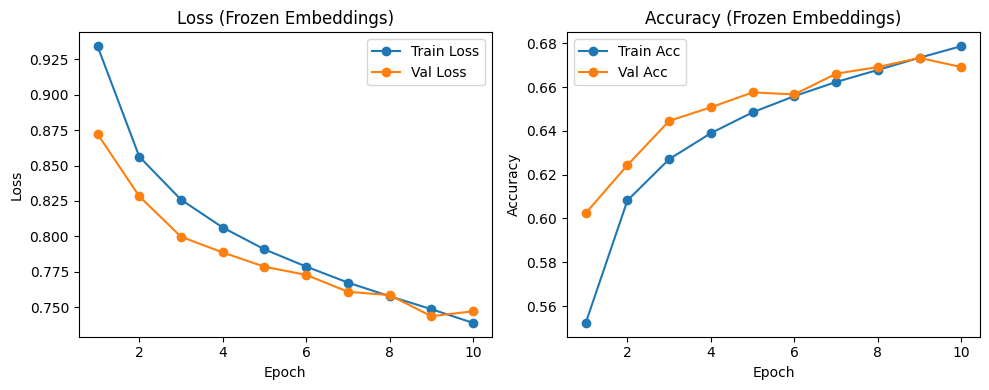

In [ ]:
###################################
# 1) Initialize the Frozen Model
###################################
model_frozen = BiLSTMWithAttention(
    vocab_size=len(word_to_index),   
    embedding_dim=embedding_dim,     # e.g. 50, 100, 300, ...
    hidden_dim=512,                  # LSTM hidden size
    output_dim=3,                    # SNLI has 3 classes
    embedding_matrix=embedding_matrix, 
    use_pretrained=True,            # Use GloVe (or other) embeddings
    freeze_embeddings=True          # Keep them FROZEN
).to(device)

###################################
# 2) Train the Frozen Model
###################################
logs_frozen = train_and_evaluate(
    model=model_frozen,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,   
    device=device
)



Saved frozen model training logs to 'frozen_logs.csv'.


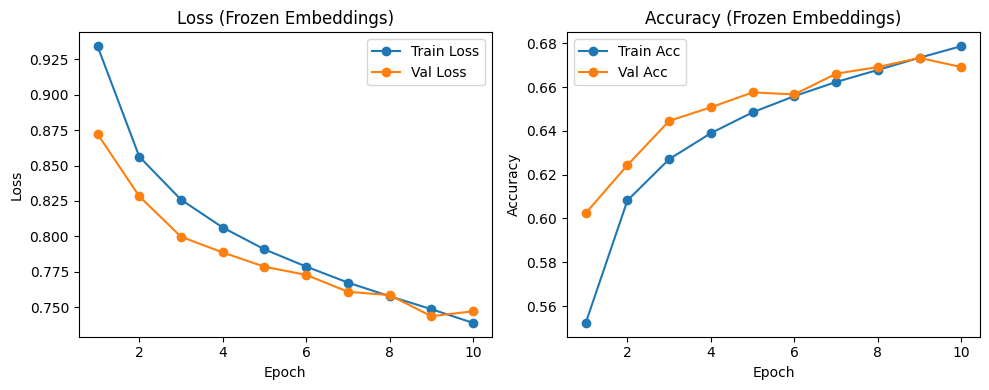

In [48]:
###################################
# 3) Convert Logs to DataFrame & Save
###################################
import pandas as pd

epochs = range(1, len(logs_frozen["train_loss"]) + 1)

# Create a DataFrame with all metrics
logs_frozen_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": logs_frozen["train_loss"],
    "val_loss": logs_frozen["val_loss"],
    "train_acc": logs_frozen["train_acc"],
    "val_acc": logs_frozen["val_acc"]
})

logs_frozen_df.to_csv("frozen_logs.csv", index=False)
print("Saved frozen model training logs to 'frozen_logs.csv'.")

###################################
# 4) Plot Training Curves
###################################
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# ---- Subplot 1: Loss vs. Epoch ----
plt.subplot(1, 2, 1)
plt.plot(epochs, logs_frozen_df["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, logs_frozen_df["val_loss"],   label="Val Loss",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Frozen Embeddings)")
plt.legend()

# ---- Subplot 2: Accuracy vs. Epoch ----
plt.subplot(1, 2, 2)
plt.plot(epochs, logs_frozen_df["train_acc"], label="Train Acc", marker='o')
plt.plot(epochs, logs_frozen_df["val_acc"],   label="Val Acc",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (Frozen Embeddings)")
plt.legend()

plt.tight_layout()
plt.show()

###################################
# (Optional) Evaluate on Test Set
###################################
# test_acc = evaluate(model_frozen, test_loader)
# print(f"Frozen Model Test Accuracy: {test_acc:.4f}")


### Evaluate on Test Set

In [49]:
test_acc = evaluate(model_frozen, test_loader)
print(f"Frozen Model Test Accuracy: {test_acc:.4f}")

Frozen Model Test Accuracy: 0.6729


### Part 2: 

In [ ]:
###################################
# 1) Initialize the Fine-tuned Model
###################################
model_finetune = BiLSTMWithAttention(
    vocab_size=len(word_to_index),   
    embedding_dim=embedding_dim,     # e.g. 50, 100, 300, ...
    hidden_dim=512,                  # LSTM hidden size
    output_dim=3,                    # SNLI has 3 classes
    embedding_matrix=embedding_matrix, 
    use_pretrained=True,            # Use GloVe (or other) embeddings
    freeze_embeddings=False         # <--- fine-tune the embeddings
).to(device)

###################################
# 2) Train the Fine-tuned Model
###################################
logs_finetune = train_and_evaluate(
    model=model_finetune,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10, 
    device=device
)




Epoch 1/10: 100%|██████████| 8584/8584 [01:46<00:00, 80.24it/s]


[Epoch 1] Train Loss: 0.8917, Train Acc: 0.5824, Val Loss: 0.8021, Val Acc: 0.6469


Epoch 2/10: 100%|██████████| 8584/8584 [01:37<00:00, 87.82it/s] 


[Epoch 2] Train Loss: 0.7962, Train Acc: 0.6470, Val Loss: 0.7707, Val Acc: 0.6633


Epoch 3/10: 100%|██████████| 8584/8584 [01:56<00:00, 73.83it/s]


[Epoch 3] Train Loss: 0.7660, Train Acc: 0.6646, Val Loss: 0.7500, Val Acc: 0.6778


Epoch 4/10: 100%|██████████| 8584/8584 [01:21<00:00, 105.43it/s]


[Epoch 4] Train Loss: 0.7482, Train Acc: 0.6752, Val Loss: 0.7396, Val Acc: 0.6853


Epoch 5/10: 100%|██████████| 8584/8584 [01:47<00:00, 80.21it/s] 


[Epoch 5] Train Loss: 0.7352, Train Acc: 0.6825, Val Loss: 0.7335, Val Acc: 0.6865


Epoch 6/10: 100%|██████████| 8584/8584 [01:54<00:00, 74.96it/s]


[Epoch 6] Train Loss: 0.7248, Train Acc: 0.6888, Val Loss: 0.7315, Val Acc: 0.6901


Epoch 7/10: 100%|██████████| 8584/8584 [01:53<00:00, 75.83it/s]


[Epoch 7] Train Loss: 0.7158, Train Acc: 0.6935, Val Loss: 0.7249, Val Acc: 0.6935


Epoch 8/10: 100%|██████████| 8584/8584 [01:55<00:00, 74.54it/s]


[Epoch 8] Train Loss: 0.7078, Train Acc: 0.6978, Val Loss: 0.7210, Val Acc: 0.6935


Epoch 9/10: 100%|██████████| 8584/8584 [01:53<00:00, 75.90it/s]


[Epoch 9] Train Loss: 0.7004, Train Acc: 0.7018, Val Loss: 0.7225, Val Acc: 0.6949


Epoch 10/10: 100%|██████████| 8584/8584 [01:56<00:00, 73.73it/s]


[Epoch 10] Train Loss: 0.6933, Train Acc: 0.7058, Val Loss: 0.7199, Val Acc: 0.6905


Saved fine-tune model training logs to 'finetune_logs.csv'.


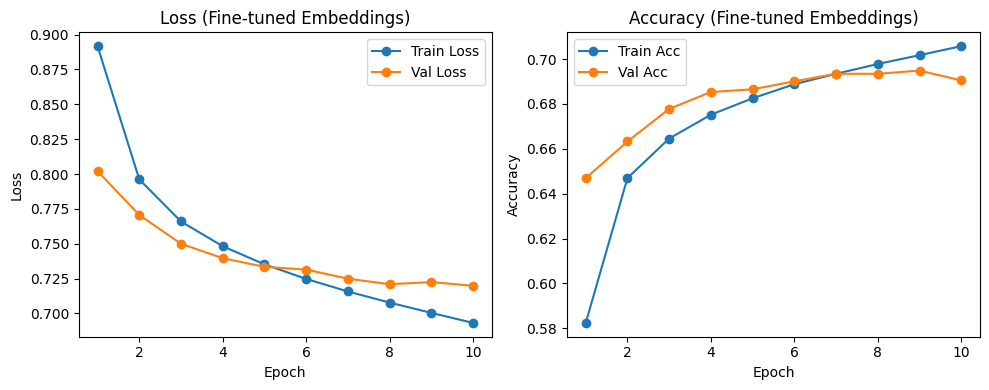

In [51]:
###################################
# 3) Convert Logs to DataFrame & Save
###################################
import pandas as pd

epochs = range(1, len(logs_finetune["train_loss"]) + 1)

# Create a DataFrame with all metrics
logs_finetune_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": logs_finetune["train_loss"],
    "val_loss": logs_finetune["val_loss"],
    "train_acc": logs_finetune["train_acc"],
    "val_acc": logs_finetune["val_acc"]
})

logs_finetune_df.to_csv("finetune_logs.csv", index=False)
print("Saved fine-tune model training logs to 'finetune_logs.csv'.")

###################################
# 4) Plot Training Curves
###################################
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# ---- Subplot 1: Loss vs. Epoch ----
plt.subplot(1, 2, 1)
plt.plot(epochs, logs_finetune_df["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, logs_finetune_df["val_loss"],   label="Val Loss",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Fine-tuned Embeddings)")
plt.legend()

# ---- Subplot 2: Accuracy vs. Epoch ----
plt.subplot(1, 2, 2)
plt.plot(epochs, logs_finetune_df["train_acc"], label="Train Acc", marker='o')
plt.plot(epochs, logs_finetune_df["val_acc"],   label="Val Acc",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (Fine-tuned Embeddings)")
plt.legend()

plt.tight_layout()
plt.show()




In [52]:
test_acc = evaluate(model_finetune, test_loader)
print(f"Fine-tuned Model Test Accuracy: {test_acc:.4f}")

Fine-tuned Model Test Accuracy: 0.6800


### Part 3 : Model Scratch      

In [ ]:
###################################
# 1) Initialize the Scratch Model
###################################
model_scratch = BiLSTMWithAttention(
    vocab_size=len(word_to_index),  
    embedding_dim=embedding_dim,    # e.g. 50, 100, 300, ...
    hidden_dim=512,                 # LSTM hidden size
    output_dim=3,                   # SNLI has 3 classes
    embedding_matrix=None,         # No external embeddings used
    use_pretrained=False,          # <-- signals random init
    freeze_embeddings=False        # <-- typically still train them
).to(device)

###################################
# 2) Train the Scratch Model
###################################
logs_scratch = train_and_evaluate(
    model=model_scratch,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,  
    device=device
)



Epoch 1/10: 100%|██████████| 8584/8584 [01:42<00:00, 83.60it/s] 


[Epoch 1] Train Loss: 0.9417, Train Acc: 0.5438, Val Loss: 0.8753, Val Acc: 0.5976


Epoch 2/10: 100%|██████████| 8584/8584 [01:36<00:00, 88.82it/s] 


[Epoch 2] Train Loss: 0.8509, Train Acc: 0.6118, Val Loss: 0.8199, Val Acc: 0.6340


Epoch 3/10: 100%|██████████| 8584/8584 [01:53<00:00, 75.71it/s]


[Epoch 3] Train Loss: 0.8139, Train Acc: 0.6348, Val Loss: 0.7948, Val Acc: 0.6485


Epoch 4/10: 100%|██████████| 8584/8584 [01:58<00:00, 72.65it/s]


[Epoch 4] Train Loss: 0.7907, Train Acc: 0.6494, Val Loss: 0.7794, Val Acc: 0.6586


Epoch 5/10: 100%|██████████| 8584/8584 [01:48<00:00, 79.25it/s] 


[Epoch 5] Train Loss: 0.7720, Train Acc: 0.6602, Val Loss: 0.7660, Val Acc: 0.6638


Epoch 6/10: 100%|██████████| 8584/8584 [01:44<00:00, 82.38it/s] 


[Epoch 6] Train Loss: 0.7566, Train Acc: 0.6691, Val Loss: 0.7596, Val Acc: 0.6727


Epoch 7/10: 100%|██████████| 8584/8584 [01:26<00:00, 98.94it/s] 


[Epoch 7] Train Loss: 0.7518, Train Acc: 0.6719, Val Loss: 0.7561, Val Acc: 0.6697


Epoch 8/10: 100%|██████████| 8584/8584 [01:23<00:00, 103.00it/s]


[Epoch 8] Train Loss: 0.7333, Train Acc: 0.6823, Val Loss: 0.7497, Val Acc: 0.6784


Epoch 9/10: 100%|██████████| 8584/8584 [01:21<00:00, 105.97it/s]


[Epoch 9] Train Loss: 0.7206, Train Acc: 0.6895, Val Loss: 0.7458, Val Acc: 0.6784


Epoch 10/10: 100%|██████████| 8584/8584 [01:39<00:00, 86.27it/s] 


[Epoch 10] Train Loss: 0.7075, Train Acc: 0.6962, Val Loss: 0.7469, Val Acc: 0.6771


Saved scratch model training logs to 'scratch_logs.csv'.


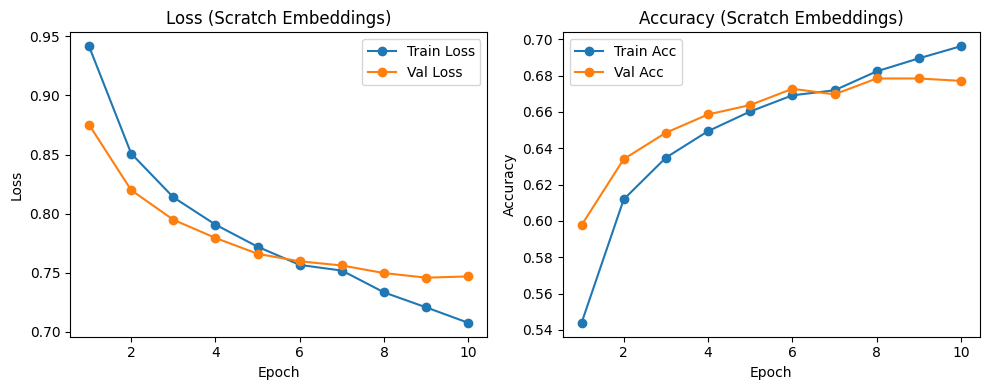

In [69]:
###################################
# 3) Convert Logs to DataFrame & Save
###################################
import pandas as pd

epochs = range(1, len(logs_scratch["train_loss"]) + 1)

logs_scratch_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": logs_scratch["train_loss"],
    "val_loss": logs_scratch["val_loss"],
    "train_acc": logs_scratch["train_acc"],
    "val_acc": logs_scratch["val_acc"]
})

logs_scratch_df.to_csv("scratch_logs.csv", index=False)
print("Saved scratch model training logs to 'scratch_logs.csv'.")

###################################
# 4) Plot Training Curves
###################################
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# ---- Subplot 1: Loss vs. Epoch ----
plt.subplot(1, 2, 1)
plt.plot(epochs, logs_scratch_df["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, logs_scratch_df["val_loss"],   label="Val Loss",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Scratch Embeddings)")
plt.legend()

# ---- Subplot 2: Accuracy vs. Epoch ----
plt.subplot(1, 2, 2)
plt.plot(epochs, logs_scratch_df["train_acc"], label="Train Acc", marker='o')
plt.plot(epochs, logs_scratch_df["val_acc"],   label="Val Acc",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (Scratch Embeddings)")
plt.legend()

plt.tight_layout()
plt.show()




In [70]:
test_acc = evaluate(model_scratch, test_loader)
print(f"Scratch Model Test Accuracy: {test_acc:.4f}")

Scratch Model Test Accuracy: 0.6666
